In [2348]:
import os
import numpy as np
import pandas as pd
import cv2
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
from sklearn.cluster import KMeans

In [9]:
import zipfile
import io
zf = zipfile.ZipFile(io.BytesIO(uploaded['g2-ts.zip']), "r")
zf.extractall()

In [1022]:
!dir data_g2

 Volume in drive C has no label.
 Volume Serial Number is 1EB9-42ED

 Directory of C:\Users\dkushn\cv@ucu2020\Hw3\data_g2

24.10.2020  20:45    <DIR>          .
24.10.2020  20:45    <DIR>          ..
24.10.2020  20:45    <DIR>          g2-gt-pa
24.10.2020  20:43            23я714 g2-gt-pa.zip
24.10.2020  20:44    <DIR>          g2-gt-txt
24.10.2020  20:43            19я554 g2-gt-txt.zip
24.10.2020  20:20    <DIR>          g2-txt
               2 File(s)         43я268 bytes
               5 Dir(s)  299я906я441я216 bytes free


In [1025]:
mypath

'data_g2/g2-txt'

In [1068]:
datapath = "data_g2/g2-gt-txt"
resultingClusters = [f for f in listdir(datapath) if isfile(join(datapath, f))]
resultingClusters[42]

'g2-2-20-gt.txt'

In [2362]:
DATA_POINTS_DIR = "data_g2/g2-txt"
DATA_EXPECTED_CLUSTER_CENTER_DIR = "data_g2/g2-gt-txt"

In [2446]:
datasets = [f for f in listdir(DATA_POINTS_DIR) if isfile(join(DATA_POINTS_DIR, f))]

In [2364]:
def LoadDataFromDir(dirname):
    dataSamples = []
    onlyfiles = [f for f in listdir(dirname) if isfile(join(dirname, f))]
    for filename in tqdm(onlyfiles):
        df = pd.read_csv(join(dirname, filename), header=None, delim_whitespace=True)
        dataSamples.append(df.to_numpy())
    return dataSamples

In [2365]:
inputDatasets = LoadDataFromDir(DATA_POINTS_DIR)

In [2366]:
inputDatasets[1].shape

(2048, 1)

In [2367]:
for dataset in inputDatasets:
    assert(dataset.shape[0] == 2048)

In [2368]:
expectedCentroids = LoadDataFromDir(DATA_EXPECTED_CLUSTER_CENTER_DIR)

In [2369]:
# All input data have to clusters
for centroids in expectedCentroids:
    assert(centroids.shape[0] == 2)

In [2370]:
# datasets and centroids presumably are matched correctly: shapes of data members are matching
for dataset, centroids in zip(inputDatasets, expectedCentroids):
    assert(dataset.shape[1] == centroids.shape[1])

# Running 2d sample code

In [2688]:
points = inputDatasets[44]
expected_centroid_pair = expectedCentroids[44]
data_dim = points.shape[1]

# All required info is accumulated in n-dimentional 'histogram' of counted values

In [2689]:
values, counts = np.unique(points, return_counts=True, axis=0)

In [2690]:
domain_span = (values.min(axis=0), values.max(axis=0))
domain_span

(array([386, 370], dtype=int64), array([733, 725], dtype=int64))

In [2691]:
def GetPointDistance(p1, p2):
    pwise_dist = p2 - p1
    return np.sqrt(pwise_dist@pwise_dist)

In [2692]:
points.shape

(2048, 2)

In [2693]:
def PlaceDataOnSpan(data_span, points):
    canvas = np.zeros((domain_span[1] - domain_span[0]))
    for p in points:
        point_span_pos = p - domain_span[0] - 1
        canvas[ tuple(point_span_pos)  ] += 1
    return canvas

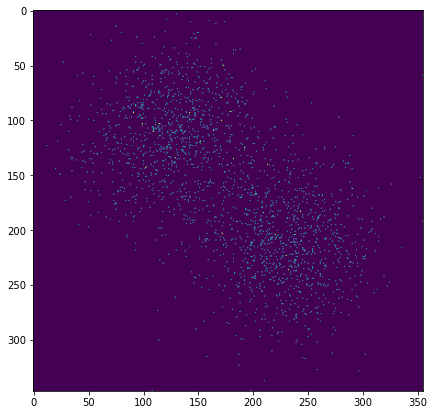

In [2694]:
if (data_dim == 1):
    plt.bar(values.flatten(), counts)
elif (data_dim == 2):
    plt.figure(figsize=(7, 7))
    image = PlaceDataOnSpan(domain_span, points)
    plt.imshow(image)
    

In [2695]:
print("dim1 span [{}:{}]".format(domain_span[0][0], domain_span[1][0]))

dim1 span [386:733]


In [2808]:
initPos

[596, 640]

In [2811]:
np.any(np.abs(values[0] - initPos) > 20)

True

In [2822]:
# uses simple radial kernel
def MeanShiftIteration(values, counts, kernelR, initPos, verbose=True):
    kernelRInFirstDim = np.zeros_like(values[0])
    kernelRInFirstDim[0] = kernelR
    kernelLowerLim = np.maximum(domain_span[0][0], initPos[0]-kernelR)
    kernelUpperLim = np.minimum(domain_span[1][0], initPos[0]+kernelR)
    
    # np.argmax returns first value which is 'True'. Effectively we get lower_bound.
    boundingBoxLowIndex = np.argmax(values[:,0]>kernelLowerLim)
    # Culd happen to be out of valid indices, but invalid index used in slicing is ok.
    boundingBoxHightIndex = np.argmax(values[:,0]>kernelUpperLim-1) + 1
    
    if verbose:
        print("KernelLowerLimit = ", kernelLowerLim)
        print("KernelUpeprLimit = ", kernelUpperLim)
        print("clusterCenter =", initPos)
        print("lowerLimFirstDim =", boundingBoxLowIndex)
        print("upperLimFirstDim =", boundingBoxHightIndex)
        print("usedCluster R = ", kernelR)
    
    n_points = 0
    sum_points = np.zeros_like(values[0])
    for p_count, p_val in zip(counts[boundingBoxLowIndex:boundingBoxHightIndex],
                              values[boundingBoxLowIndex:boundingBoxHightIndex]):
        offsetFromCenter = p_val - initPos
        l2FromCenter = np.sqrt(offsetFromCenter@offsetFromCenter)
        if (l2FromCenter < kernelR):
            n_points += p_count
            sum_points += p_val * p_count
    
    #Note: used type in64 is large enough as accumulator for given dataset.
    if n_points != 0:
        newMeanPoint = sum_points / n_points
    else:
        newMeanPoint = initPos
    
    if verbose:
        print("pointsInSpan =", n_points)
        print("accum = ", sum_points)
        print("meanPoints =", newMeanPoint)
    
    return newMeanPoint

In [2697]:
def MeanShift(points, values, counts, initialPos, domain_span, usedRadius, max_iter, verbose=False):

    domain_range = domain_span[1] - domain_span[0]
    domain_range_distance = np.sqrt(domain_range@domain_range)

    convergence_criterion = 1
    shiftDistance = 2
    it = 0
    max_color = counts.max()
    history = []
    while shiftDistance > 0 and it < max_iter:
        updatedPos = MeanShiftIteration(values, counts, usedRadius, initialPos, verbose=False)
        shift = updatedPos - initialPos
        shiftDistance = np.sqrt(shift@shift)
        history.append((initialPos, updatedPos))
        initialPos = updatedPos
        it += 1

    if (verbose):
        print("domain_range_from = ", domain_span[0])
        print("domain_range_to = ", domain_span[1])
        print("domain_range = ", domain_range)
        print("domain_range_dist = ", domain_range_distance)
        if shift.sum() < convergence_criterion:
            print("Converged in {} iterations".format(it))
        
    return initialPos, history

In [2698]:
def Draw2DConvergence(points, counts, domain_span, means_history):
    assert(points.shape[1] == 2)
    max_color = counts.max()
    canvas = Draw2dData(domain_span, points)
    for initialPos, updatedPos in means_history:
        displayedCenter = initialPos - domain_span[0]
        iPosDisp = initialPos - domain_span[0]
        nPosDisp = updatedPos - domain_span[0]

        shift = updatedPos - initialPos
        shift_len = np.sqrt(shift@shift)

        canvas = cv2.line(canvas, 
                 (int(iPosDisp[0]), int(iPosDisp[1])),
                 (int(nPosDisp[0]), int(nPosDisp[1])),
                 color = shift_len // max_color,
                 thickness=2
                )
    plt.imshow(canvas)
    plt.show()

In [2699]:
# TODO: add heuristics to determine optimal number of sample points. Maybe use non-random sampling strategy.

In [2836]:
# Expected that in few iterations such heuristics will find several very distant points in dataset.
def GetRadius2(points):
    p = points[0]
    data_diagonal_len = 0
    for i in range(4):
        distances = [GetPointDistance(p, p2) for p2 in points]
        distant_point_index = np.argmax(distances)
        p = points[distant_point_index]
        data_diagonal_len = distances[distant_point_index]
        
    return data_diagonal_len/2

In [2834]:
def GetRadius(domain_span, n_points):
    # Using such a radius that with given data and dimentionality we'll have enought points to move.
    dv = domain_span[1] - domain_span[0]
    domain_volume = dv@dv
    kernelRadius = 8*np.sqrt(domain_volume / n_points)
    return kernelRadius

In [2799]:
def RunMeanShiftOnDataset(points, values, counts, domain_span, kernelRadius, max_iter=10, visualizeHistory=False):
    clustered_regions = []
    
    for data_point in tqdm(points):
    #     initialPose = np.random.uniform(low=domain_span[0], high=domain_span[1])

        finalMeanPos, history = MeanShift(points,
                                          values,
                                          counts,
                                          data_point,
                                          domain_span,
                                          kernelRadius,
                                          max_iter=max_iter,
                                          visualize=False)
        clustered_regions.append((data_point, finalMeanPos))
        if(visualizeHistory):
            print(initialPose)
            print(finalMeanPos)
            Draw2DConvergence(points, counts, domain_span, history)
    return clustered_regions

In [2702]:
number_of_points

2048

In [2703]:
dv = domain_span[1] - domain_span[0]
domain_volume = dv@dv
print(domain_volume)
kernelRadius = 4*np.sqrt(domain_volume / 2048) 
kernelRadius

246434


43.87784891035567

In [2704]:
number_of_points = points.shape[0]
kernelRaius = GetRadius(domain_span, number_of_points)
print("UsedRadius :", kernelRadius)
clustered_regions = RunMeanShiftOnDataset(points, values, counts, domain_span, kernelRaius, visualizeHistory=False)

UsedRadius : 43.87784891035567


In [2733]:
grouped_regions = GroupClusteredRegions(clustered_regions, 10)
[len(gr_r) for gr_r in grouped_regions]

[986, 1035, 12, 5, 2, 5, 1, 1, 1]

In [2737]:
[len(gr_r) for gr_r in grouped_regions]

[986, 1035, 12, 5, 2, 5, 1, 1, 1]

In [2736]:
merged_groups = MergeGroups2(grouped_regions)
[len(gr_r) for gr_r in merged_groups]

[986, 1035, 12, 5, 2, 5, 1, 1, 1]
[6 7 8 4 3 5 2 0 1]


[1053, 995]

In [2794]:
def DisplayInintConvergedPairs(points, domain_span, clustered_regions):
    assert(domain_span[0].shape[0] == 2)
    plt.figure(figsize=(10, 10))
    
    canvas =  PlaceDataOnSpan(domain_span, points)

    for init_p, converged_p in clustered_regions:
        disp_init = init_p - domain_span[0]
        disp_conv = converged_p - domain_span[0]

        cv2.line(canvas,
                (int(disp_init[0]), int(disp_init[1])),
                (int(disp_conv[0]), int(disp_conv[1])),
                 1,
                 1)
    for init_p, converged_p in clustered_regions:
        disp_init = init_p - domain_span[0]
        disp_conv = converged_p - domain_span[0]

        cv2.circle(canvas,
                (int(disp_conv[0]), int(disp_conv[1])),
                 1,
                 3)
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas)
    return canvas

<Figure size 720x720 with 0 Axes>

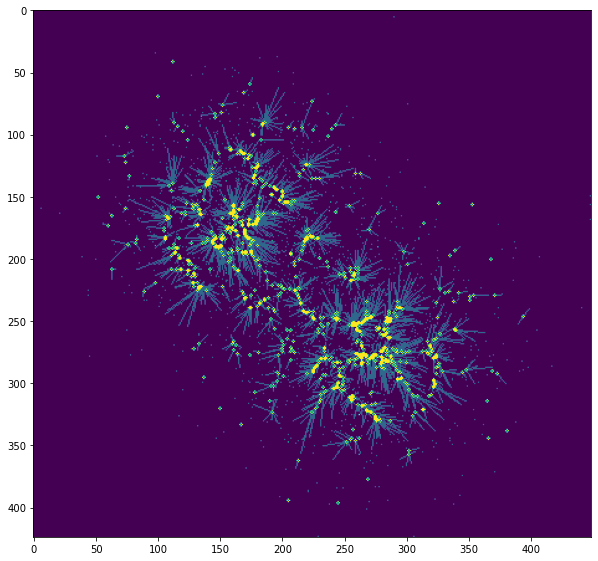

In [2795]:
if data_dim == 2:
    DisplayInintConvergedPairs(points, domain_span, clustered_regions)

In [2514]:
cluster_candidates = [el[1] for el in clustered_regions]

In [2515]:
def GetPointDistance(p1, p2):
    pwise_dist = p2 - p1
    return np.sqrt(pwise_dist@pwise_dist)

In [2711]:
# clustered_regions

In [2593]:
grouped_CR = GroupClusteredRegions(clustered_regions, 20)
print([len(cr)for cr in grouped_CR])


[870, 5, 10, 2, 970, 5, 3, 46, 23, 4, 1, 2, 13, 2, 3, 5, 1, 27, 5, 1, 15, 1, 1, 1, 2, 12, 4, 1, 1, 4, 2, 1, 1, 2, 2]


In [2591]:
def GroupClusteredRegions(clustered_regions, acceptance_distance):
    groups=[]
    for p_init, p_converged in tqdm(clustered_regions):
        hasGroup = False
        for group in groups:
            if hasGroup:
                break
            for _, gp in group:
                dist = GetPointDistance(p_converged, gp)
                if dist < acceptance_distance:
                    hasGroup = True
                    group.append((p_init, p_converged))
                    break
        if not hasGroup:
            groups.append([ (p_init, p_converged) ])
    return groups

In [2516]:
def GroupPoints(points, group_distance):
    groups=[]
    for p in tqdm(points):
        hasGroup = False
        for group in groups:
            if hasGroup:
                break
            for gp in group:
                dist = GetPointDistance(p, gp)
                if dist < group_distance:
                    hasGroup = True
                    group.append(p)
                    break
        if not hasGroup:
            groups.append([p])
    return groups

In [2714]:
groups = GroupPoints(cluster_candidates, 30)

In [2715]:
sortedSizeGroups = sorted(groups, key=lambda x: len(x), reverse=True)

In [2573]:
print(len(groups))

4


In [2574]:
for gr in sortedSizeGroups:
    print(len(gr))

In [2522]:
#sortedSizeGroups[0]

In [2523]:
predicted_cluster_centroids = []
predicted_cluster_centroids.append(np.round(np.mean(sortedSizeGroups[0], axis=0)))
predicted_cluster_centroids.append(np.round(np.mean(sortedSizeGroups[1], axis=0)))

In [2524]:
predicted_cluster_centroids[1]

array([598., 596.])

In [2525]:
expected_centroid_pair

array([[500, 500],
       [600, 600]], dtype=int64)

In [2526]:
centroids_error = expected_centroid_pair - predicted_cluster_centroids
print("Centroids error :", centroids_error.flatten())

Centroids error : [-20. -22.   2.   4.]


In [2438]:
# Checking if we have ambiguity with selected constant.
assert(GetPointDistance(predicted_cluster_centroids[0], predicted_cluster_centroids[1]) > 2*CLUSTER_ACCEPTANCE_R)

In [2786]:
def CheckAssignment(points, myPA):
    
    expectedPA = np.array([ 1 if i < points.shape[0]//2 else 2 for i in range(points.shape[0]) ]) 
    
    n_assigned_correctly = (expectedPA == myPA).sum()
    
    # Indexes id should be changed.
    if (n_assigned_correctly < expectedPA.size // 2):
        expectedPA = np.flip(expectedPA)
        n_assigned_correctly = (expectedPA == myPA).sum()
    
    n_missasigned = expectedPA.size - n_assigned_correctly
    
    return n_assigned_correctly, n_missasigned

In [2529]:
correct_assignments, unassigned, missasigned = CheckAssignment(points,
                                                               resulting_clusters)


print("AssignedCorrectly: ", correct_assignments)
print("Unassigned: ", unassigned)
print("Missasigned: ", missasigned)

AssignedCorrectly:  1969
Unassigned:  0
Missasigned:  79


# Run on all datasets

In [2713]:
print([len(gr)for gr in groups])

[2045, 6]


In [ ]:
group_means = [np.mean(gr, axis=0)for gr in groups]
group_means

In [2685]:
group_sizes = [len(gr)for gr in groups]
group_sizes

[2045, 6]

In [2678]:
np.argsort(group_sizes)

array([0, 1], dtype=int64)

In [2729]:
merged_groups = MergeGroups2(grouped_regions)
[len(gr_r) for gr_r in merged_groups]

[8014, 8658, 12, 5, 2, 5, 1, 1, 1]
[6 7 8 4 3 5 2 0 1]


[8676, 16037]

In [2818]:
# Selecting 2 largest clusters and merge all the others to them.
def MergeGroups2(groups):
    group_sizes = [len(gr)for gr in groups]
    sorted_sizes_idx = np.argsort(group_sizes)
    
    largest_idx = sorted_sizes_idx[-1]
    second_largest_idx = sorted_sizes_idx[-2]

    # Use mean for each group as position.
    group_means = [ np.mean([c for i, c in gr], axis=0) for gr in groups ]
    
    # Spread into two domains
    groups_to_second = []
    groups_to_first = []
    for i_gr, gr in enumerate(groups):
        if i_gr == largest_idx or i_gr == second_largest_idx:
            continue
        
        dist_to_largest = GetPointDistance(group_means[i_gr], group_means[largest_idx])
        dist_to_second_largest = GetPointDistance(group_means[i_gr], group_means[second_largest_idx])
        if dist_to_largest < dist_to_second_largest:
            groups_to_first.append(gr)
        else:
            groups_to_second.append(gr)
            
    merged_groups = [groups[largest_idx].copy(), groups[second_largest_idx].copy()]
    for gr in groups_to_first:
        merged_groups[0].extend(gr)
    for gr in groups_to_second:
        merged_groups[1].extend(gr)

    return merged_groups

In [2640]:
# On each oteration finding smallest group, then group closest to it with larger size. Megre smaller into larger.
# Strategy is not optimal, because has some misses on delimiting line, yet working.
def MergeGroups(groups):
    n_groups = len(groups)
    while n_groups > 2:
        group_sizes = [len(gr)for gr in groups]
        sg_idx = np.argmin(group_sizes)
        sg_size = group_sizes[sg_idx]
        
#         converged_pts = [c for i, c in groups]
        group_means = [ np.mean([c for i, c in gr], axis=0) for gr in groups ]
        sg_mean = group_means[sg_idx]
        
        
        distances_to_smallest = [(GetPointDistance(sg_mean, g_mean), g_id) \
                                 for g_id, g_mean in enumerate(group_means)\
                                if sg_size != group_sizes[g_id]]
        merge_to = np.argmin(distances_to_smallest)
        groups[merge_to].extend(groups.pop(sg_idx))
        n_groups = len(groups)
    return groups

In [2746]:
print(predicted_cluster_centroids)
predicted_cluster_centroids.reverse()
print(predicted_cluster_centroids)


[array([598., 597.]), array([498., 500.])]
[array([498., 500.]), array([598., 597.])]


In [2748]:
np.sum(predicted_cluster_centroids)

2193.0

In [2791]:
data_dim

2

In [ ]:
dataset_history = []

for points, expected_centroid_pair, dataset_name in zip(inputDatasets[51:], expectedCentroids[51:], datasets[51:]):
    
    print()
    print("Processing: ", dataset_name)
    data_dim = points.shape[1]
    print("DataDim :", data_dim)
    values, counts = np.unique(points, return_counts=True, axis=0)
    domain_span = (values.min(axis=0), values.max(axis=0))
    
    ds = domain_span[1] - domain_span[0]
    volume = ds@ds
    CLUSTER_ACCEPTANCE_R = np.sqrt(volume) / 100
    print("Grouping acceptance R:", CLUSTER_ACCEPTANCE_R)
    
    it = 0
    n_groups = -1
    groups = []
    n_points=points.shape[0]
#     kernelRadius = GetRadius(domain_span, n_points=n_points)
    kernelRadius = GetRadius2(points)
    
    print("kernel R:", kernelRadius)
    oldScore = -1
    oldSortedSizeGroups = []
    sortedSizeGroups = []
    
    # Grouping is a faster procedure, tuning this parameter
#     while True:
#         probe_grouping = GroupPoints(points, kernelRadius)
#         if len(probe_grouping) > n_points//2:
#             kernelRadius *= 1.3
#         else:
#             break
    print("Clustering...")    
    
    while it < 10:
        
        
        clustered_regions = RunMeanShiftOnDataset(points,
                                                  values,
                                                  counts,
                                                  domain_span,
                                                  kernelRadius,
                                                  max_iter=100,
                                                  visualizeHistory=False)
        
        used_cluster_acceptance_r = CLUSTER_ACCEPTANCE_R
        oldClusteringRScore = 0.5
        oldGroups = []
        groups = []
    
        # Attempt to optimize by increasing CLUSTER_ACCEPTANCE_R
        kernelRUpdateIter = 0
        while kernelRUpdateIter < 5:
        
            if data_dim == 2:
                print("Drawing data")
                canvas = DisplayInintConvergedPairs(points, domain_span, clustered_regions)
                plt.imshow(canvas)
                plt.show()

            groups = GroupClusteredRegions(clustered_regions, used_cluster_acceptance_r)
            n_groups = len(groups)
            if n_groups < 20:
                print("Groups:", [len(gr)for gr in groups])
            else:
                print("GroupsLen: ", len(groups))

            originalGroupsSorted = sorted(groups, key=lambda x: len(x), reverse=True)
            originalSizeOfFirstGroup = len(originalGroupsSorted[0])

            nInSecondGroup = -1
            if len(originalGroupsSorted) > 1:
                nInSecondGroup = len(originalGroupsSorted[1])
            else:
                nInSecondGroup = 0
                
            kernelRUpdateIter += 1
            
            # Best fit is for case when second group contains exactly half of points,
            # case of only one group is always the worst one
            clusteringRScore = abs(0.5 - nInSecondGroup / n_points)
            
            if clusteringRScore <= oldClusteringRScore:
                oldClusteringRScore = clusteringRScore
                used_cluster_acceptance_r *= 2
                print("AcceptanceR Increase to= ", used_cluster_acceptance_r)
            else:
                print("AcceptanceR Old Score [{}], AcceptanceRLastScore [{}]".format(oldClusteringRScore,
                                                                                     clusteringRScore))
                groups = oldGroups
                break
        
        
        # Best fit is for case when second group contains exactly half of points,
        # case of only one group is always the worst one
        score = abs(0.5 - nInSecondGroup / n_points)
        print("Score:", score)
        
        if n_groups > 2:
            groups = MergeGroups2(groups)
        print("Merged groups:", [len(gr)for gr in groups])
        
        sortedSizeGroups = sorted(groups, key=lambda x: len(x), reverse=True)
        
        # We could decreese step for R search here, but computation is already expensive.
        if oldScore != -1 and oldScore < score:
            print("OldScore {} score {}".format(oldScore, score))
            # Case when previous result was better, and we avoid osscilation of R
            sortedSizeGroups = oldSortedSizeGroups
            break
        else:
            oldScore = score
            oldSortedSizeGroups = sortedSizeGroups
        
        
        # in this case we have had exactly halve of data in first cluster, split is good.
        if abs(len(sortedSizeGroups[0]) - n_points//2) < 100:
            break
        
        # Seeds are not converging.
        if n_groups > n_points//4:
            kernelRadius *= 1.3
        # All points are aggregated into one cluster. Case of R is too large and has to be decreased.  
        elif len(sortedSizeGroups[0]) > (n_points//2):
            kernelRadius /= 1.3
            
        print("new kernelRadius :", kernelRadius)  
            
        it += 1
        
    print(len(sortedSizeGroups))
    predicted_cluster_centroids = []
    predicted_cluster_centroids.append(np.round(np.mean([c for i, c in sortedSizeGroups[0]], axis=0)))
    predicted_cluster_centroids.append(np.round(np.mean([c for i, c in sortedSizeGroups[1]], axis=0)))
    
    centroids_error = expected_centroid_pair - predicted_cluster_centroids
    predicted_cluster_centroids.reverse()
    centroids_error2 = expected_centroid_pair - predicted_cluster_centroids
    
    # Checking 1-2 or 2-1 is correct.
    if np.sum(np.abs(centroids_error2)) < np.sum(np.abs(centroids_error)):
        selected_centroids_error = centroids_error2
    else:
        selected_centroids_error = centroids_error
    print("Centroids error :", selected_centroids_error)
    
    
    resulting_clusters = np.zeros( (points.shape[0]) )
    first_cluster_init_points = [ initPoint for initPoint, _ in sortedSizeGroups[0]]
    second_cluster_init_points = [ initPoint for initPoint, _ in sortedSizeGroups[1]]
    for i_p, p in enumerate(points):
        if  (first_cluster_init_points == p).all(axis=1).any():
            resulting_clusters[i_p] = 1
        else:
            resulting_clusters[i_p] = 2
            
    correct_assignments, misassigned = CheckAssignment(points,
                                                       resulting_clusters)

    print("AssignedCorrectly: ", correct_assignments)
    print("Missasigned: ", misassigned)
    
    dataset_history.append( {"dataset_name":dataset_name,
                             "kernel_radius":kernelRadius,
                             "centroids_error":selected_centroids_error,
                             "correct_assignments":correct_assignments,
                             "misassigned":misassigned} )


Processing:  g2-256-100.txt
DataDim : 256
Grouping acceptance R: 119.9479708040115
kernel R: 1672.7419107561095
Clustering...



GroupsLen:  2048
AcceptanceR Increase to=  239.895941608023



GroupsLen:  2048
AcceptanceR Increase to=  479.791883216046



GroupsLen:  2048
AcceptanceR Increase to=  959.583766432092



GroupsLen:  2048
AcceptanceR Increase to=  1919.167532864184



GroupsLen:  1900
AcceptanceR Increase to=  3838.335065728368
Score: 0.4931640625
Merged groups: [1580, 468]
new kernelRadius : 2174.5644839829424



Groups: [2048]
AcceptanceR Increase to=  239.895941608023



Groups: [2048]
AcceptanceR Increase to=  479.791883216046



Groups: [2048]
AcceptanceR Increase to=  959.583766432092



Groups: [2048]
AcceptanceR Increase to=  1919.167532864184



Groups: [2048]
AcceptanceR Increase to=  3838.335065728368
Score: 0.5
Merged groups: [2048]
OldScore 0.4931640625 score 0.5
2
Centroids error : [[-30. -32. -12. -17. -16. -28. -26. -22. -16. -16. -34. -21. -24. -11.
  -34.  -9. -26. -20. -15. -20. -29. -28. -48. -21. -14. -20. -16. -26.
  -17. -20. -17. -26. -35. -36. -14. -29. -31. -46. -29. -14. -34. -19.
  -25. -17. -13. -40. -28. -21. -34. -30. -35. -30. -37. -38. -38. -26.
  -23. -26. -22. -18. -26. -27. -10. -25. -27. -22. -34. -18. -27. -23.
    1. -33. -24. -29. -32. -14. -15. -10. -17. -16. -22. -31. -33. -30.
  -28. -25. -28. -34. -14. -25. -46. -16. -20.  -2. -46. -36. -35. -20.
  -29. -20. -19. -29. -31. -27. -31. -37. -24. -29. -31. -32. -14. -18.
  -31. -17. -30. -10. -25. -39. -10. -18. -34. -29. -25. -38. -37.  -4.
  -33. -19. -21. -31. -14. -20. -34. -49. -15. -18. -36. -13. -24. -34.
  -24. -22. -27. -28. -23. -36. -36. -46. -24. -34. -16. -20. -20. -24.
  -36. -21. -20. -20. -41. -24. -22. -24. -31. -22. -18. -15. -

In [ ]:
dataset_history

# Нотатки виконання завдання:

Оглянув межі завдання, вирішив скомбінувати виконання п.1 та п.4: написати MeanShift та перевірити його на даних датасетах.
Вирішив зробити це в GoogleColab (зручніше зробити якщо це щось просте, легше перевіряти й шерити)
Спробував працювати з датасетом у форматі .ts. Подумав про .ts пов'язаний з форматом MPEG, можливо там кадр або кілька 
кадрів з розподілом точок
Ідея виявилася хибною. Отже це time series з R. 
Спробува встановити пакунки для роботи над timeSeries експортованими з R.
Зрозумів що даремно витрачаю час і створюю незручності для майбутньох перевірки. Перейов до роботи з txt.
Спробував прочитати і пропарсити вручну адже формат тривіальний. При зчитуванні багатовимірних точок код став
занадто ускладненим, тому переробив це через pandas.

Почав з одновимірних даних.
Візуалізував точки як вони є, інформативність посередня. Перейшов до np.unique(return_counts=True), надалі 
працював з такими агрегованими даними як для візуалізації так і для обробки.

Обрав для роботи кернел у вигляді кола.
Зробив імпліментацію MeanShift для одновимірних даних. Реалізація тривіальна, в одному вимірі 
коло перетворюється в span. Візуалізував рух міну, збіжність спостерігається.

Перейшов до узагальнення до 2х вимірів, узагальнюючи код для роботи з n-вимірними даними.
Підхід зі span в 1 вимірі залишився у вигляді bounding_box для зменшення кількості індексів що розглядаються 
принаймні по першому виміру (вирішив не робити кілька пересортованих списків для кожного виміру, швидкодія може й програти).

Доволі багато зусиль пішло на адаптацію і дебаг коду, яка поверталася кілька разів (приклад малюнку нижче)

Алгоритм кластеризації маючи мін_шифт зробив наступним чином:
    
    
Проблема постала на кроці адаптації на дані з великою кількістю вимірів: покласти результуючі центри кластерів
    у n-вимірний масив щоб застосувати блюр і отримати консолідований центр кластеру не виходить для розмірності простору 
    > 32 через обмеження numpy. Підглянув у відкритій імпліментації mean_shift ідею групування точок. (імпліментував сам,
проблема була у відсутності ідеї як це зробити не за квадратичний час)

Зрозумів що ідея перевіряти довільні точки ініціалізації алгоритму була хибною, адже зі зростанням розмірності
точки в датасеті стають дуже віддалені, тоді набагато доцільнішою ідеєю видається перебрати всі точки
як початкові, це так само знімає задачу по розмітці простору на кластери, як це робилося до того, адже всі необхідні
точки будуть розмічені.

Окіл потрібно обрати таким чином щоб він залежав від об'єму в якому відбувається пошук. Перевірка на датасеті показала, що однаковий розмір не підходить для всіх прикладів з однаковим баундінг боксом для даних, тому додав скейлінг: збільшуємо радіус, якщо кількість кластерів завелика та зменшуємо, якщо всі точки потрапили в один кластер.


Добряче часу втратилося на роботу з лістами в Пайтоні які не завжди бажають копіюватися.

Найбільше зусиль і часу витратилося на вдосконалення полісі з пошуку умов ініціалізації для багатовимірних даних.
Спала на думку евристика щодо пошуку віддалених точок в розподілі: починаємо з випадкової точки, знаходимо найдальшу від неї - така точка повинна лежати на зовніщній межі розподілу. Повторюємо процедуру кілька разів, точки будуть прагнути до діаметра описаного кола. Половина цієї відстані видається хорошою ідеєю для початкової ініціалізації радіуса для міншифт кернела.

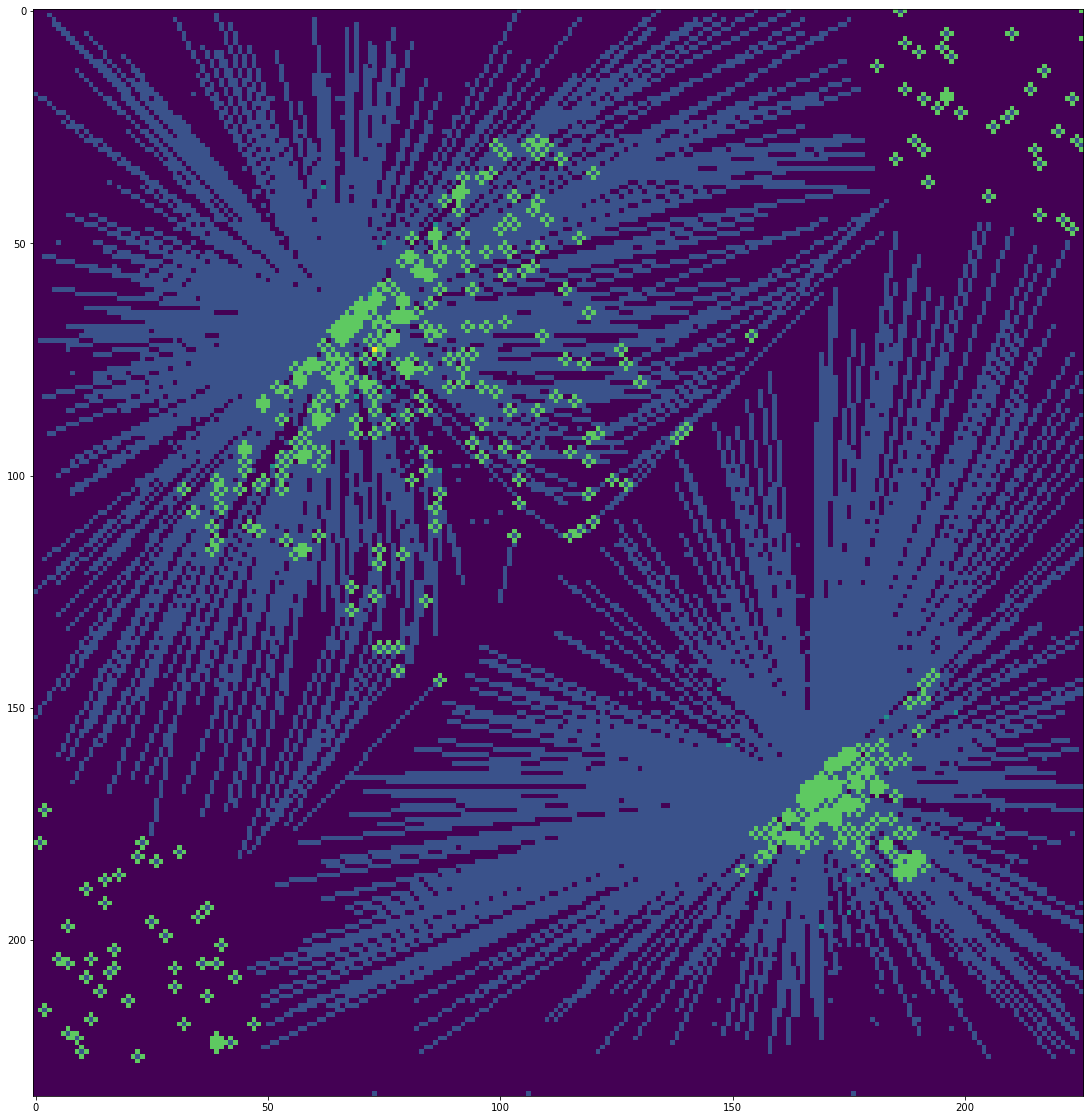

In [922]:
plt.figure(figsize=(20, 20))
plt.imshow(canvas)

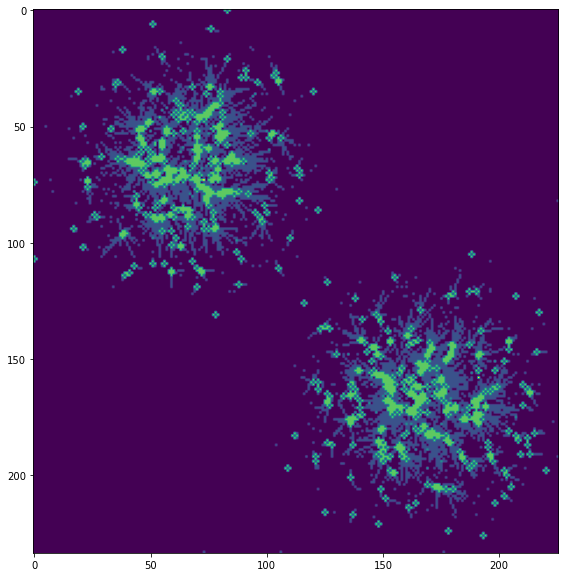

In [1831]:
plt.figure(figsize=(10, 10))
plt.imshow(canvas)